In [1]:
import numpy as np
import os
import sys
from os import listdir
from os.path import isfile, join, exists, split
import matplotlib.pyplot as plt
import time
#import cortex
import nibabel as nib
import importlib

import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

#from helpers import helpers

#importlib.reload(helpers)

/usr/people/ps6938/miniconda3/envs/pygers/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
sub = 'sub-001'
session = 'ses-01'

# bids directory
homedir = '/jukebox/norman/pscotti/fuji/data/bids'

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub)
maskdir = join(homedir,'derivatives','masks', sub)
designdir = '/jukebox/norman/pscotti/fuji/data/design/'
outputdir = join(homedir,'derivatives',f'glmsingle_{session}/')
ses1_dir = join(datadir,f'{session}','func/')
defaced_dir = join(homedir,'derivatives','deface/')

In [5]:
#Load brain mask
file_in = maskdir + '/%s_%s_brain.nii.gz' % (sub, "ses-01")
print('Loading average brain mask:', file_in)
print('')
avg_mask=nib.load(file_in)

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

Loading average brain mask: /jukebox/norman/pscotti/fuji/data/bids/derivatives/masks/sub-001/sub-001_ses-01_brain.nii.gz

Mask dimensions: (1.8, 1.8, 1.8)

Affine:
[[  1.79999995   0.           0.         -68.92620087]
 [  0.           1.79999995   0.         -84.57213593]
 [  0.           0.           1.79999995 -49.80442429]
 [  0.           0.           0.           1.        ]]

There are 170266.0 voxels in the included brain mask



In [6]:
# get some info about epi data by loading study run 1
epi_file=datadir + '/ses-01/func/%s_ses-01_task-imagery_run-01_space-T1w_desc-preproc_bold.nii.gz' % (sub)
epi_data=nib.load(epi_file)
run1=epi_data.get_fdata()

print('checking epi data for run 1:', epi_file)
print('')
epi_dimsize=epi_data.header.get_zooms()
epi_affine=epi_data.affine
print('Dimensions:', epi_dimsize)
print('Affine:')
print(epi_data.affine)
print('')

# get shape of data volume (XYZ) for convenience
xyz = run1.shape[:3]
xyzt = run1.shape
print(xyz)
print(xyzt)

# double check that brain mask and epi data have same dimensions and affine
assert avg_mask.header.get_zooms() == epi_dimsize[:3]
assert avg_mask.affine.all() == epi_data.affine.all()

checking epi data for run 1: /jukebox/norman/pscotti/fuji/data/bids/derivatives/fmriprep/sub-001/ses-01/func/sub-001_ses-01_task-imagery_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (1.8, 1.8, 1.8, 1.8)
Affine:
[[  1.79999995   0.           0.         -68.92620087]
 [  0.           1.79999995   0.         -84.57213593]
 [  0.           0.           1.79999995 -49.80442429]
 [  0.           0.           0.           1.        ]]

(76, 96, 77)
(76, 96, 77, 185)


In [7]:
datasets = ['v1']#, 'v2', 'v3'] #glmsingle versions

info = dict()
info['v1'] = dict()
info['v2'] = dict()
info['v3'] = dict()
info['v1']['subjs'] = ['sub-001']
info['v2']['subjs'] = ['sub-001']
info['v3']['subjs'] = ['sub-001']
info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']

In [8]:
loaddir='/jukebox/norman/pscotti/fuji/data/bids/derivatives/glmsingle/sub-001/'
reliability = dict()

#masks = np.load('masks.npy',allow_pickle=True).item() 

# check to be sure all the datafiles exist
for ds in datasets:
    
    reliability[ds] = dict()
    
    for subj in info[ds]['subjs']:
        
        subj_version_list = []
        
        reliability[ds][subj] = dict()

        # load this versions's data
        if ds == 'v1':    
            temp = np.load(join(loaddir,'voxel_reliabilities_NSDgeneral_v1.npy')) 
            method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
        elif ds == 'v2':
            temp = np.load(join(loaddir,'voxel_reliabilities_NSDgeneral_v2.npy')) 
            method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
        elif ds == 'v3':
            temp = np.load(join(loaddir,'voxel_reliabilities_NSDgeneral_v3.npy')) 
            method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise_rr'] #glmdenoise was actually turned off 
        
        for method in method_list:
            if method == 'assumehrf':
                idx=0
            elif method == 'fithrf':
                idx=1
            elif method == 'fithrf_glmdenoise':
                idx=2
            elif method == 'fithrf_glmdenoise_rr':
                if ds == 'v3':
                    idx=2
                else:
                    idx=3

            rel = temp[idx]
            #rel = np.load(metric_savefn)
                    
            #mask = masks[ds][subj]==1
            
            #if np.ndim(rel) == 3:
                #rel = rel[mask==1]
                
            print(ds,method,subj,rel.shape)
            
            reliability[ds][subj][method] = rel
            
            subj_version_list.append(rel)
                       
        reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/jukebox/norman/pscotti/fuji/data/bids/derivatives/glmsingle/sub-001/voxel_reliabilities_NSDgeneral_v1.npy'

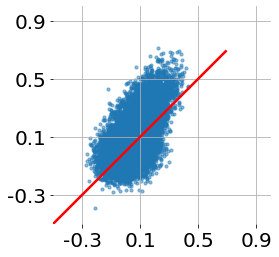

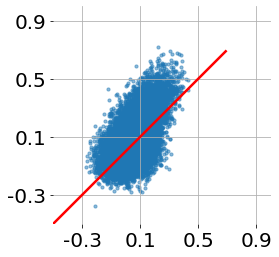

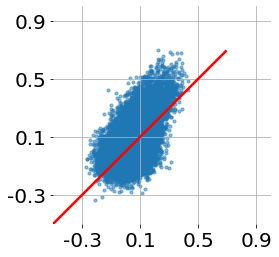

In [8]:
x_version = 'assumehrf'
y_version = 'fithrf_glmdenoise_rr'

# iterate through datasets
for ds in datasets:
    for subj in info[ds]['subjs']:

        #x = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][x_version], masks[ds][subj])
        #y = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][y_version], masks[ds][subj])
        x = reliability[ds][subj][x_version]
        y = reliability[ds][subj][y_version]

        #x[masks[ds][subj] < 1] = np.nan
        #y[masks[ds][subj] < 1] = np.nan

        plt.figure(figsize=(4,4))
        plt.grid('on')
        plt.scatter(x, y, 10, alpha = 0.5)
        plt.axis('square')

        plt.plot(np.arange(-0.6,0.7,0.01),np.arange(-0.6,0.7,0.01),'r',linewidth=2.5,zorder=10)

        if ds == 'mindeye':
            ticks = (-0.3,0.8,0.4)
        else:
            ticks = (-0.3,1,0.4)

        plt.xticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
                   np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)
        plt.yticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
                   np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)

        if ds == 'mindeye':
            plt.xlim([-0.5,0.75])
            plt.ylim([-0.5,0.75])
        else:
            plt.xlim([-0.5,1])
            plt.ylim([-0.5,1])

        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

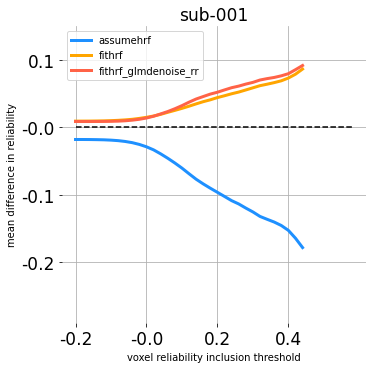

In [9]:
ft = 16
#versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
versions = ['assumehrf','fithrf','fithrf_glmdenoise_rr']
colors = ['dodgerblue','orange','tomato']

bins  = np.round(np.arange(-0.2,0.6,0.02),3)

measure = 'mean'
min_nvox = 50

allsubj_diffs = dict()

for ds in datasets:
    allsubj_diffs[ds] = dict()
    for method in versions:
        allsubj_diffs[ds][method] = []

plt.figure(figsize=(12,12))
c = 1

# iterate through datasets
for ds in ['v3']:
            
    # iterate through subjects
    for subj in info[ds]['subjs']:
        
        plt.subplot(len(ds),2,c)
        
        subj_mean_metric = reliability[ds][subj]['mean']
        
        subj_version_diffs = []
        
        # iterate through versions
        v=0
        for method in versions:
    
            this_version = reliability[ds][subj][method]
            this_version_diffs = []
            this_version_stds = []
            for val in bins:
                
                validvox = subj_mean_metric > val
              
                if np.sum(validvox) > min_nvox:
                    if measure == 'mean':
                        this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                    elif measure == 'median':
                        this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
                    this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
                else:
                    #print(val,'ahhh')
                    this_version_diffs.append(np.nan)
                    this_version_stds.append(np.nan)
                    
            
            subj_version_diffs.append(this_version_diffs)
            plt.plot(this_version_diffs,linewidth=3,color = colors[v])
            
            v+=1
            
            allsubj_diffs[ds][method].append(this_version_diffs)
        
        c+=1
        plt.plot(np.zeros((len(bins),)),'k--')
        plt.xticks(np.arange(len(bins))[::10],np.array(bins[::10]),fontsize=ft);
        
        if ds == 'NSD':
            plt.yticks(np.round(np.arange(-0.4,0.3,0.1),2),np.round(np.arange(-0.4,0.3,0.1),2),fontsize=ft)
            plt.ylim([-0.21,0.21])
        else:
            plt.yticks(np.round(np.arange(-0.4,0.3,0.1),2),np.round(np.arange(-0.4,0.3,0.1),2),fontsize=ft)
            plt.ylim([-0.29,0.15])
       
        plt.xticks(fontsize=ft+1)
        plt.yticks(fontsize=ft+1)
        plt.title(subj,fontsize=ft+1)
        plt.xlabel('voxel reliability inclusion threshold')
        plt.ylabel('mean difference in reliability')
        plt.grid('on')         
        plt.legend(versions,loc='upper left')
        # get rid of the frame
        for spine in plt.gca().spines.values():
            spine.set_visible(False)